This script estimates vehicle depreciation using panel data pulled from CarGurus.

In [164]:
import pandas as pd
import numpy as np
import os
import plotly.express as px
import statsmodels.api as sm
import colorcet as cc
from datetime import date

In [117]:
# load data for CPI to deflate prices
# normalize CPI to January 2025
cpi_df = pd.read_csv('./input_data/CPIAUCSL.csv')
cpi_df['observation_date'] = pd.to_datetime(cpi_df['observation_date'])
cpi_df['CPIAUCSL'] = cpi_df['CPIAUCSL'] / cpi_df.loc[cpi_df['observation_date']=='2025-01-01', 'CPIAUCSL'].values

# function to assign generations
def wrangler_generation(year):
    year = int(year)
    if 1987 <= year <= 1995:
        return 'YJ'
    elif 1997 <= year <= 2006:
        return 'TJ'
    elif 2007 <= year <= 2017:
        return 'JK'
    elif 2018 <= year:
        return 'JL'

# load data for Jeep Wrangler
wrangler_df = pd.concat([pd.read_csv('./input_data/' + x) for x in os.listdir('./input_data') if 'wrangler' in x])

# drop nulls
wrangler_df.dropna(inplace=True)

# transform datatypes
wrangler_df['Date'] = pd.to_datetime(wrangler_df['Date'])
wrangler_df['Price'] = pd.to_numeric(wrangler_df['Price'])

# sort by date for CPI merge
wrangler_df.sort_values(by='Date', inplace=True)

# merge CPI on closest date
wrangler_df = pd.merge_asof(wrangler_df, cpi_df, left_on='Date', right_on='observation_date')

# deflate price
wrangler_df['Real Price'] = wrangler_df['Price'] / wrangler_df['CPIAUCSL']

# remove prices <= 0 or >= 100,000
wrangler_df = wrangler_df.loc[(wrangler_df['Price'] > 0) & (wrangler_df['Price'] < 100000)]

# sort by model year and date
wrangler_df.sort_values(by=['Car Type','Date'], inplace=True)

# calculate age = max of (date - start of model-year) or (date - earliest date) + 1
# this is to handle situations where model-years are released the year before (e.g. 2025 sold in 2024)
wrangler_df['Age'] = pd.concat([(wrangler_df['Date'] - pd.to_datetime(wrangler_df['Car Type'].str.slice(0,4))).dt.days,
                                (wrangler_df['Date'] - wrangler_df.groupby('Car Type')['Date'].transform('min')).dt.days
                               ], axis=1).max(axis=1) + 1
wrangler_df['Age2'] = wrangler_df['Age']**2

# create multiindex--useful for linearmodels PanelOLS but not needed for statsmodels OLS
wrangler_df.set_index(['Car Type', 'Date'], inplace=True)

# get dummies for generation and model year (Car Type)
# use generation dummies instead of time trend, which would be collinear with age
wrangler_df['Generation'] = wrangler_df.index.get_level_values('Car Type').str.extract(r'(\d{4})')[0].astype(int).apply(wrangler_generation).values
wrangler_df = pd.concat([wrangler_df, 
                         pd.get_dummies(wrangler_df['Generation'], prefix='Gen', drop_first=False, dtype=int),
                         pd.get_dummies(wrangler_df.reset_index()['Car Type'], prefix='CT', drop_first=False, dtype=int).set_index(wrangler_df.index)
                        ], axis=1)

# function to assign generations
def runner_generation(year):
    year = int(year)
    if 1984 <= year <= 1989:
        return 'First'
    elif 1990 <= year <= 1995:
        return 'Second'
    elif 1996 <= year <= 2002:
        return 'Third'
    elif 2003 <= year <= 2009:
        return 'Fourth'
    elif 2010 <= year <= 2024:
        return 'Fifth'
    elif 2025 <= year:
        return 'Sixth'

# load data for Toyota 4runner
runner_df = pd.concat([pd.read_csv('./input_data/' + x) for x in os.listdir('./input_data') if 'runner' in x])

# drop nulls
runner_df.dropna(inplace=True)

# transform datatypes
runner_df['Date'] = pd.to_datetime(runner_df['Date'])
runner_df['Price'] = pd.to_numeric(runner_df['Price'])

# sort by date for CPI merge
runner_df.sort_values(by='Date', inplace=True)

# merge CPI on closest date
runner_df = pd.merge_asof(runner_df, cpi_df, left_on='Date', right_on='observation_date')

# deflate price
runner_df['Real Price'] = runner_df['Price'] / runner_df['CPIAUCSL']

# remove prices <= 0 or >= 100,000
runner_df = runner_df.loc[(runner_df['Price'] > 0) & (runner_df['Price'] < 100000)]

# sort by model year and date
runner_df.sort_values(by=['Car Type','Date'], inplace=True)

# calculate age = max of (date - start of model-year) or (date - earliest date) + 1
# this is to handle situations where model-years are released the year before (e.g. 2025 sold in 2024)
runner_df['Age'] = pd.concat([(runner_df['Date'] - pd.to_datetime(runner_df['Car Type'].str.slice(0,4))).dt.days,
                                (runner_df['Date'] - runner_df.groupby('Car Type')['Date'].transform('min')).dt.days
                               ], axis=1).max(axis=1) + 1
runner_df['Age2'] = runner_df['Age']**2

# create multiindex--useful for linearmodels PanelOLS but not needed for statsmodels OLS
runner_df.set_index(['Car Type', 'Date'], inplace=True)

# get dummies for generation and model year (Car Type)
# use generation dummies instead of time trend, which would be collinear with age
runner_df['Generation'] = runner_df.index.get_level_values('Car Type').str.extract(r'(\d{4})')[0].astype(int).apply(runner_generation).values
runner_df = pd.concat([runner_df, 
                         pd.get_dummies(runner_df['Generation'], prefix='Gen', drop_first=False, dtype=int),
                         pd.get_dummies(runner_df.reset_index()['Car Type'], prefix='CT', drop_first=False, dtype=int).set_index(runner_df.index)
                        ], axis=1)

In [120]:
wrangler_y = ['Real Price']
wrangler_x = [['Age', 'Age2'], 
              [col for col in wrangler_df.columns if col.startswith("Gen_")][1:],
              [col for col in wrangler_df.columns if col.startswith("CT_")][1:]
             ]
wrangler_x = sum(wrangler_x, [])
wrangler_reg = sm.OLS(wrangler_df[wrangler_y], sm.add_constant(wrangler_df[wrangler_x])).fit()

runner_y = ['Real Price']
runner_x = [['Age', 'Age2'], 
            [col for col in runner_df.columns if col.startswith("Gen_")][1:],
            [col for col in runner_df.columns if col.startswith("CT_")][1:]
           ]
runner_x = sum(runner_x, [])
runner_reg = sm.OLS(runner_df[runner_y], sm.add_constant(runner_df[runner_x])).fit()

In [122]:
display(wrangler_reg.summary())
display(runner_reg.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Real Price   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     1218.
Date:                Sun, 20 Apr 2025   Prob (F-statistic):               0.00
Time:                        09:34:35   Log-Likelihood:                -27422.
No. Observations:                2942   AIC:                         5.492e+04
Df Residuals:                    2902   BIC:                         5.516e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             3.742e+04    160.865    232.592      0.000    3.71e+04    3.77e+04
Age                 -5.8603      0.074    -79.509      0.000      -6.005      -5.716
Age2                 0.0004   5.35e-06     68.137      0.000       0.000       0.000
Gen_JL            1.078e+04    279.049     38.642      0.000    1.02e+04    1.13e+04
Gen_TJ           -2193.2873    143.790    -15.253      0.000   -2475.227   -1911.347
Gen_YJ           -6324.0730    367.947    -17.187      0.000   -7045.536   -5602.610
CT_1988 Wrangler  -598.0017    389.442     -1.536      0.125   -1361.613     165.610
CT_1989 Wrangler   696.2763    392.008      1.776      0.076     -72.366    1464.918
CT_1990 Wrangler   184.3928    394.497      0.467      0.640    -589.129     957.915
CT_1991 Wrangler   866.3450    396.899      2.183      0.029      88.113    1644.577
CT_1992 Wrangler   810.5608    401.239      2.020      0.043      23.818    1597.303
CT_1993 Wrangler  1022.2871    404.533      2.527      0.012     229.087    1815.487
CT_1994 Wrangler  1100.7141    408.721      2.693      0.007     299.301    1902.127
CT_1995 Wrangler   725.5252    413.019      1.757      0.079     -84.314    1535.365
CT_1997 Wrangler -2204.3025    266.275     -8.278      0.000   -2726.409   -1682.196
CT_1998 Wrangler -1693.7214    264.145     -6.412      0.000   -2211.652   -1175.790
CT_1999 Wrangler -1223.5672    262.454     -4.662      0.000   -1738.183    -708.952
CT_2000 Wrangler  -887.2375    261.177     -3.397      0.001   -1399.349    -375.126
CT_2001 Wrangler  -799.7409    260.308     -3.072      0.002   -1310.147    -289.335
CT_2002 Wrangler  -575.6682    259.868     -2.215      0.027   -1085.213     -66.123
CT_2003 Wrangler   331.4734    259.895      1.275      0.202    -178.124     841.071
CT_2004 Wrangler  1027.6988    260.448      3.946      0.000     517.017    1538.381
CT_2005 Wrangler  1816.3106    261.612      6.943      0.000    1303.347    2329.275
CT_2006 Wrangler  2015.4677    263.478      7.649      0.000    1498.845    2532.090
CT_2007 Wrangler   165.3529    270.365      0.612      0.541    -364.774     695.480
CT_2008 Wrangler   837.4005    267.982      3.125      0.002     311.946    1362.855
CT_2009 Wrangler  1079.4216    266.561      4.049      0.000     556.754    1602.089
CT_2010 Wrangler  1638.0311    275.220      5.952      0.000    1098.384    2177.678
CT_2011 Wrangler  2387.4567    283.728      8.415      0.000    1831.127    2943.786
CT_2012 Wrangler  4124.6013    290.042     14.221      0.000    3555.893    4693.310
CT_2013 Wrangler  4569.5204    300.628     15.200      0.000    3980.054    5158.987
CT_2014 Wrangler  5293.7662    312.766     16.926      0.000    4680.501    5907.032
CT_2015 Wrangler  5342.1155    326.765     16.348      0.000    4701.401    5982.830
CT_2016 Wrangler  4854.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Real Price   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     898.9
Date:                Sun, 20 Apr 2025   Prob (F-statistic):               0.00
Time:                        09:34:35   Log-Likelihood:                -30277.
No. Observations:                3138   AIC:                         6.064e+04
Df Residuals:                    3094   BIC:                         6.091e+04
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            4.593e+04    244.465    187.870      0.000    4.54e+04    4.64e+04
Age                -8.1825      0.100    -81.674      0.000      -8.379      -7.986
Age2                0.0005   7.06e-06     73.895      0.000       0.001       0.001
Gen_First       -1.827e+04   1847.244     -9.891      0.000   -2.19e+04   -1.46e+04
Gen_Fourth      -3980.3345    229.871    -17.316      0.000   -4431.049   -3529.620
Gen_Second      -7896.4458    320.665    -24.625      0.000   -8525.184   -7267.708
Gen_Sixth        8558.0074   1844.623      4.639      0.000    4941.198    1.22e+04
Gen_Third       -6154.4963    282.283    -21.803      0.000   -6707.978   -5601.015
CT_1985 4Runner  3081.6063   1958.467      1.573      0.116    -758.421    6921.634
CT_1986 4Runner  8877.4244   1934.630      4.589      0.000    5084.136    1.27e+04
CT_1987 4Runner  1.056e+04   1935.326      5.456      0.000    6765.035    1.44e+04
CT_1988 4Runner  1.023e+04   1930.984      5.296      0.000    6439.558     1.4e+04
CT_1989 4Runner  9080.8594   1935.438      4.692      0.000    5285.986    1.29e+04
CT_1990 4Runner -2663.0231    360.623     -7.385      0.000   -3370.107   -1955.939
CT_1991 4Runner -2285.0288    355.261     -6.432      0.000   -2981.601   -1588.457
CT_1992 4Runner -1491.1198    353.084     -4.223      0.000   -2183.423    -798.817
CT_1993 4Runner  -705.3752    352.068     -2.004      0.045   -1395.686     -15.065
CT_1994 4Runner  -505.8241    350.515     -1.443      0.149   -1193.090     181.442
CT_1995 4Runner  -246.0748    351.295     -0.700      0.484    -934.871     442.721
CT_1996 4Runner -1416.7926    359.088     -3.946      0.000   -2120.867    -712.718
CT_1997 4Runner  -966.9337    356.765     -2.710      0.007   -1666.453    -267.414
CT_1998 4Runner -1071.4550    355.064     -3.018      0.003   -1767.639    -375.271
CT_1999 4Runner  -794.9402    353.929     -2.246      0.025   -1488.901    -100.980
CT_2000 4Runner  -353.3536    353.340     -1.000      0.317   -1046.159     339.452
CT_2001 4Runner  -681.4919    353.303     -1.929      0.054   -1374.224      11.240
CT_2002 4Runner  -869.5293    353.851     -2.457      0.014   -1563.335    -175.723
CT_2003 4Runner -2145.0788    359.608     -5.965      0.000   -2850.173   -1439.985
CT_2004 4Runner -1656.5583    356.738     -4.644      0.000   -2356.026    -957.091
CT_2005 4Runner -1232.3866    354.514     -3.476      0.001   -1927.494    -537.280
CT_2006 4Runner  -429.2896    353.114     -1.216      0.224   -1121.652     263.073
CT_2007 4Runner   -72.0264    352.726     -0.204      0.838    -763.627     619.574
CT_2008 4Runner   697.9938    353.565      1.974      0.048       4.748    1391.240
CT_2009 4Runner   857.0115    357.131      2.400      0.016     156.774    1557.249
CT_2010 4Runner  2510.1364    421.943      5.949      0.000

In [190]:
# calculate age depreciation for a 2022 Wrangler versus 2022 4Runner
display(wrangler_reg.params['const'] + 
        wrangler_reg.params['Age'] * (date.today() - date(2022, 1, 1)).days +
        wrangler_reg.params['Age2'] * (date.today() - date(2022, 1, 1)).days**2 +
        wrangler_reg.params['Gen_JL'] + 
        wrangler_reg.params['CT_2022 Wrangler']
       )

display(runner_reg.params['const'] + 
        runner_reg.params['Age'] * (date.today() - date(2022, 1, 1)).days +
        runner_reg.params['Age2'] * (date.today() - date(2022, 1, 1)).days**2 +
        0 + 
        runner_reg.params['CT_2022 4Runner']
       )

46343.24431674568

44579.084847737424

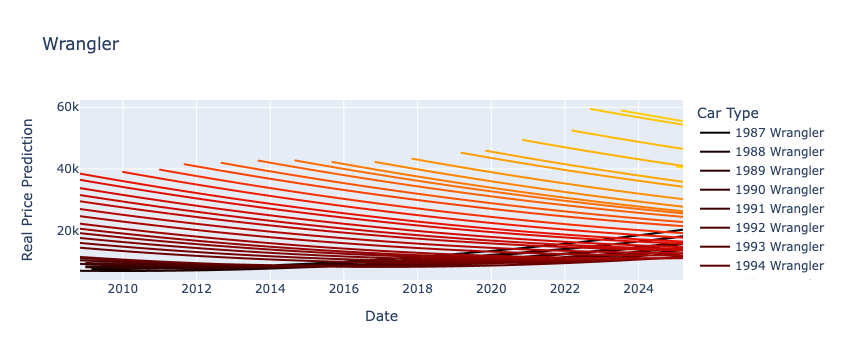

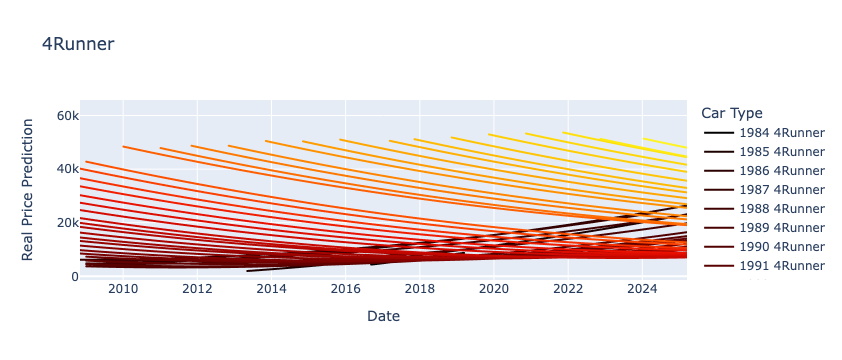

In [156]:
px.line(pd.DataFrame(wrangler_reg.fittedvalues, columns=['Real Price Prediction']).reset_index(),
        x='Date',
        y='Real Price Prediction',
        color='Car Type',
        color_discrete_sequence=cc.palette['fire'][::6],
        title='Wrangler'
       ).show()

px.line(pd.DataFrame(runner_reg.fittedvalues, columns=['Real Price Prediction']).reset_index(),
        x='Date',
        y='Real Price Prediction',
        color='Car Type',
        color_discrete_sequence=cc.palette['fire'][::6],
        title='4Runner'
       ).show()